In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [3]:
import os
import sys
import math
import pyspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

In [4]:
import os
os.environ['SPARK_LOCAL_IP']='127.0.0.1'

In [7]:
os.environ['SPARK_HOME'] = "/opt/homebrew/Cellar/apache-spark/3.5.3/libexec"
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
#os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['PYSPARK_PYTHON'] = 'python'

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"PySpark version: {pyspark.__version__}")

System version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
Pandas version: 2.2.3
PySpark version: 3.5.3


In [11]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.mllib.recommendation import ALS as ALS_m
from pyspark.ml.evaluation import RegressionEvaluator 
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType



In [12]:
#!/opt/homebrew/Cellar/apache-spark/3.5.3/libexec/bin/spark-shell --driver-memory 5g

In [13]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
conf = SparkConf()

In [14]:
#conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '20g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g'), ("spark.sql.shuffle.partitions", "16"),("spark.driver.maxResultSize","4g"),("spark.sql.execution.arrow.enabled", "true")])

In [19]:
conf.setExecutorEnv(pairs =[('spark.executor.memory', '70g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','40g'), ("spark.sql.shuffle.partitions", "200"),("spark.driver.maxResultSize","12g"),("spark.sql.execution.arrow.enabled", "true"),("spark.memory.offHeap.enabled","true"),("spark.memory.offHeap.size","50g")])

In [21]:
print(conf.toDebugString())

spark.executorEnv.spark.executor.memory=70g
spark.executorEnv.spark.app.name=Spark Updated Conf
spark.executorEnv.spark.executor.cores=4
spark.executorEnv.spark.cores.max=4
spark.executorEnv.spark.driver.memory=40g
spark.executorEnv.spark.sql.shuffle.partitions=200
spark.executorEnv.spark.driver.maxResultSize=12g
spark.executorEnv.spark.sql.execution.arrow.enabled=true
spark.executorEnv.spark.memory.offHeap.enabled=true
spark.executorEnv.spark.memory.offHeap.size=50g


In [23]:
# from pyspark import SparkContext
# SparkContext.setSystemProperty('spark.executor.memory', '10g')

In [25]:
#spark.sparkContext.stop()

In [27]:
#spark = SparkSession.builder.appName('Recommender').getOrCreate() 
#spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark = SparkSession.builder.appName('Recommender ALS').config(conf=conf).getOrCreate() 
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")
spark.sparkContext.setLogLevel("ERROR")
#spark.conf.set("spark.executor.memory", "10g")
#spark.conf.set("spark.executor.cores", "2")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/08 16:37:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [29]:
spark.sparkContext.setLogLevel("ERROR")

In [31]:
input_data=spark.read.csv('df_final_data.csv',inferSchema=True,header=True)
input_data.show(3)

+--------+-----------+------------+-------------------+-----------------------------+-------------------+----------+---------+-----+-------------+-----------+---------+------------+-------------------+------------------+----------------+-----------------+-----------------+----------------+--------------+------------+------------------+------------------------+-------------+--------------+
|order_id|customer_id|order_status| order_purchased_at|order_estimated_delivery_date|order_item_quantity|product_id|seller_id|price|freight_value|total_value|review_id|review_score|   product_category|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|   seller_city|seller_state|customer_unique_id|customer_zip_code_prefix|customer_city|customer_state|
+--------+-----------+------------+-------------------+-----------------------------+-------------------+----------+---------+-----+-------------+-----------+---------+------------+-------------------+---------------

In [32]:
print((input_data.count(), len(input_data.columns)))

(98464, 25)


In [33]:
input_data.filter(input_data['customer_unique_id'].isNotNull()).count()

98464

In [34]:
input_data.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchased_at: timestamp (nullable = true)
 |-- order_estimated_delivery_date: date (nullable = true)
 |-- order_item_quantity: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- total_value: double (nullable = true)
 |-- review_id: integer (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product_photos_qty: double (nullable = true)
 |-- product_weight_g: double (nullable = true)
 |-- product_length_cm: double (nullable = true)
 |-- product_height_cm: double (nullable = true)
 |-- product_width_cm: double (nullable = true)
 |-- seller_city: string (nullable = true)
 |-- seller_state: string (nullable = true)
 |-- customer_unique_id: i

In [35]:
input_data.groupby('product_id').agg(f.collect_set('product_category'))\
                        .filter(size(col('collect_set(product_category)')) == 1).count()

31714

In [40]:
input_data.select(f.countDistinct("product_category")).show()

+--------------------------------+
|count(DISTINCT product_category)|
+--------------------------------+
|                              73|
+--------------------------------+



In [41]:
input_data.select(f.countDistinct("customer_unique_id")).show()

+----------------------------------+
|count(DISTINCT customer_unique_id)|
+----------------------------------+
|                             94720|
+----------------------------------+



In [43]:


input_data.select(f.countDistinct("order_id")).show()

+------------------------+
|count(DISTINCT order_id)|
+------------------------+
|                   97916|
+------------------------+



In [45]:
input_data.select(f.countDistinct("product_id")).show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                     31714|
+--------------------------+



## Data Preprocessing 

## Feature Engineering

In [52]:
def preprocess(df):
    
    # Change data types
    df = df.withColumn('order_purchased_at', to_timestamp('order_purchased_at'))
    df = df.withColumn('customer_unique_id', col('customer_unique_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('order_id', col('order_id').cast('integer'))
    return df

In [54]:
def product_features(df):

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(
                                      first('product_category').alias('product_category'),
                                      countDistinct('order_id').alias('number_of_orders'),
                                      mean('price').alias('price'),
                                      mean('review_score').alias('mean_rating'),
                                      min('order_purchased_at').alias('first_date'),
                                      max('order_purchased_at').alias('last_date'),
                                      first('seller_id').alias('seller'))
    
    return df

In [56]:
def category_features(df):
    
    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('product_category').agg(avg('price').alias('average_price'))
    
    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('product_category').agg(countDistinct('product_id').alias('number_of_products'),
                                       countDistinct('order_id').alias('number_of_orders'))
                                       
  
    df = df.join(products, on='product_category')
    
    return df

In [58]:
def user_features(df):

    # Calculate several metrics for users with the aggregate function
    df = df.groupby('customer_unique_id').agg(
                                   mode('customer_city').alias('city'),
                                   mode('customer_state').alias('state'),
                                   countDistinct('product_id').alias('distinct_products_purchased'),
                                   countDistinct('order_id').alias('number_of_orders'),
                                   mode('product_category').alias('product_cat'),
                                   mode('product_id').alias('product_id'),
                                   mean('price').alias('average_price_purchased'),
                                   mean('relative_price').alias('avg_relative_price_purchased'),
                                   min('order_purchased_at').alias('first_date'),
                                   max('order_purchased_at').alias('last_date'),
                                   mean('review_score').alias('mean rating'))
    

    return df

In [60]:
def calculate_relative_price(products):
    
    categories = products.groupby('product_category').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))
    
    # Calculate relative price
    products = products.join(categories, on='product_category')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))
    
    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [62]:
df_freq = input_data.groupBy('customer_unique_id').agg(countDistinct('order_id').alias('frequency'))

In [64]:
df_freq.show()

+------------------+---------+
|customer_unique_id|frequency|
+------------------+---------+
|             41575|        1|
|             91141|        1|
|             57370|        1|
|             58305|        1|
|             51123|        1|
|              5518|        1|
|             29228|        1|
|             87616|        1|
|             69048|        1|
|             47217|        1|
|             73091|        1|
|             68579|        1|
|             27974|        1|
|             57380|        1|
|             56110|        1|
|             10362|        1|
|             94377|        1|
|             40653|        1|
|              7253|        1|
|             62985|        1|
+------------------+---------+
only showing top 20 rows



In [65]:
#df=preprocess(input_data)

In [68]:
input_data = input_data.withColumn('order_purchased_at', to_timestamp('order_purchased_at'))

In [70]:
products=product_features(input_data)
categories=category_features(input_data)

In [72]:
products.show()

+----------+--------------------+----------------+------------------+------------------+-------------------+-------------------+------+
|product_id|    product_category|number_of_orders|             price|       mean_rating|         first_date|          last_date|seller|
+----------+--------------------+----------------+------------------+------------------+-------------------+-------------------+------+
|         1|          automobile|               1|             129.9|               4.0|2017-12-12 19:20:28|2017-12-12 19:20:28|  1384|
|         3| household_utilities|               2|              58.9|               5.0|2018-08-01 22:00:33|2018-08-10 13:24:35|   769|
|         5|          cool_stuff|               2|             249.0|               5.0|2017-09-17 20:35:28|2017-09-17 20:45:13|  2484|
|         6|      consoles_games|               7| 50.01428571428572|3.2857142857142856|2017-10-28 18:16:38|2017-12-27 00:22:18|  1699|
|        12|computers_accesso...|               

In [73]:
categories.show()

+--------------------+------------------+----------------+------------------+
|    product_category|number_of_products|number_of_orders|     average_price|
+--------------------+------------------+----------------+------------------+
|fashion_bag_acces...|               777|            1845| 95.73176319176336|
|                 art|                52|             197|206.64307692307682|
|           beverages|                76|             292| 107.8257894736842|
|             flowers|                14|              26| 40.81285714285715|
|   home_construction|               213|             478|201.58901408450717|
|            pc_gamer|                 3|               8|268.99666666666667|
|fashion_male_clot...|                84|             110| 99.51845238095231|
|kitchen_dining_la...|                91|             242|234.68307692307692|
|          la_cuisine|                10|              12|           170.998|
|      bed_bath_table|              2815|            9221|127.43

In [74]:
relative_prices = calculate_relative_price(products)
relative_prices.show()
df = input_data.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')
products.show()

+----------+--------------------+
|product_id|      relative_price|
+----------+--------------------+
|     31711|-0.31041291416757966|
|     31693| -0.3534122430284204|
|     31643|  1.0611912675864548|
|     31637| 0.13153089583372024|
|     31578| 0.13153089583372024|
|     31513|-0.45262411874299796|
|     31477|   2.183255033764755|
|     31441| 0.44562667508464415|
|     31432|   3.288114558768005|
|     31359|-0.42247723741790927|
|     31312|   1.078395508761505|
|     31234|-0.26464016241744504|
|     31228| -0.4054308333178591|
|     31185|-0.22439170829232657|
|     31174|-0.18572162491721292|
|     31137|  1.0611912675864548|
|     31136|  0.1313730587587198|
|     31129|-0.26306179166744037|
|     31066| -0.5013957749181414|
|     31028|   2.167629163339709|
+----------+--------------------+
only showing top 20 rows



+----------+--------------------+----------------+------------------+-----------------+-------------------+-------------------+------+--------------------+
|product_id|    product_category|number_of_orders|             price|      mean_rating|         first_date|          last_date|seller|      relative_price|
+----------+--------------------+----------------+------------------+-----------------+-------------------+-------------------+------+--------------------+
|     31711|fashion_bag_acces...|               1|              32.0|              5.0|2017-10-06 16:44:05|2017-10-06 16:44:05|  1217|-0.31041291416757966|
|     31693|fashion_bag_acces...|               7|29.275714285714287|4.428571428571429|2017-04-26 12:11:30|2018-08-18 21:12:42|  2613| -0.3534122430284204|
|     31643|fashion_bag_acces...|               1|             118.9|              1.0|2017-10-25 23:38:10|2017-10-25 23:38:10|   175|  1.0611912675864548|
|     31637|fashion_bag_acces...|               1|              

In [76]:
users = user_features(df)
users.show()

+------------------+--------------------+-----+---------------------------+----------------+--------------------+----------+-----------------------+----------------------------+-------------------+-------------------+-----------+
|customer_unique_id|                city|state|distinct_products_purchased|number_of_orders|         product_cat|product_id|average_price_purchased|avg_relative_price_purchased|         first_date|          last_date|mean rating|
+------------------+--------------------+-----+---------------------------+----------------+--------------------+----------+-----------------------+----------------------------+-------------------+-------------------+-----------+
|                26|            brasilia|   DF|                          1|               1|       sport_leisure|     26915|                  59.99|          -0.280022390309015|2017-01-21 21:58:35|2017-01-21 21:58:35|        4.0|
|                27|   goianesia do para|   PA|                          1|     

In [78]:
df_users=users.toPandas()
recent_date=df_users['last_date'].max()
df_users['Recency'] = df_users['last_date'].apply(
    lambda x: (recent_date - x).days)
df_users.head()

,customer_unique_id,city,state,distinct_products_purchased,number_of_orders,product_cat,product_id,average_price_purchased,avg_relative_price_purchased,first_date,last_date,mean rating,Recency
0,26,brasilia,DF,1,1,sport_leisure,26915,59.99,-0.280022,2017-01-21 21:58:35,2017-01-21 21:58:35,4.0,589
1,27,goianesia do para,PA,1,1,computers_accessories,260,269.00,1.150961,2017-04-24 13:36:48,2017-04-24 13:36:48,3.0,496
2,28,santo andre,SP,1,1,luggage_accessories,15176,174.33,0.807189,2017-06-28 11:08:38,2017-06-28 11:08:38,5.0,431
3,31,sao paulo,SP,1,1,health_beauty,6507,88.00,-0.025818,2018-01-18 20:49:36,2018-01-18 20:49:36,5.0,227
4,34,jarinu,SP,1,1,bed_bath_table,19756,47.90,-0.343699,2017-04-19 11:32:09,2017-04-19 11:32:09,3.0,501


In [86]:
df_users['Recency'].describe()

count    94720.000000
mean       242.437817
std        153.163707
min          0.000000
25%        118.000000
50%        223.000000
75%        352.000000
max        728.000000
Name: Recency, dtype: float64

In [88]:
users_df=spark.createDataFrame(df_users)

In [89]:
user_ids = users_df.select('customer_unique_id').distinct()
user_ids.show()

+------------------+
|customer_unique_id|
+------------------+
|                26|
|              7225|
|              9968|
|             10422|
|             11745|
|             13401|
|             14117|
|             14846|
|             15173|
|             15846|
|             18147|
|             25207|
|             27255|
|             28242|
|             29089|
|             30928|
|             33862|
|             36103|
|             40132|
|             41988|
+------------------+
only showing top 20 rows



In [108]:
# user_ids = user_ids.coalesce(1)
# user_ids = user_ids.withColumn("userIntId", monotonically_increasing_id()).persist()
# user_ids.show()


In [111]:
# product_ids=products.select('product_id').distinct()
# product_ids = product_ids.coalesce(1)
# product_ids = product_ids.withColumn("prodIntId", monotonically_increasing_id()).persist()

In [ ]:
# products=products.join(product_ids, 'product_id', 'left')
# products.show()

Text(0.5, 1.0, 'Recency Histogram of Customers')

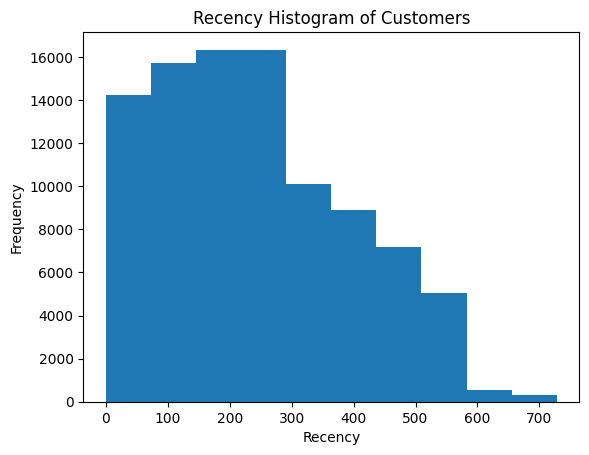

In [220]:
users_df.toPandas()['Recency'].plot.hist()
plt.xlabel('Recency')
plt.title('Recency Histogram of Customers')

/var/folders/m1/2ckvnp7j54q8hjtqgnmldg180000gn/T/ipykernel_68551/3501770629.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users_df.toPandas()['avg_relative_price_purchased'],kde=False,rug=True)


<Axes: xlabel='avg_relative_price_purchased'>

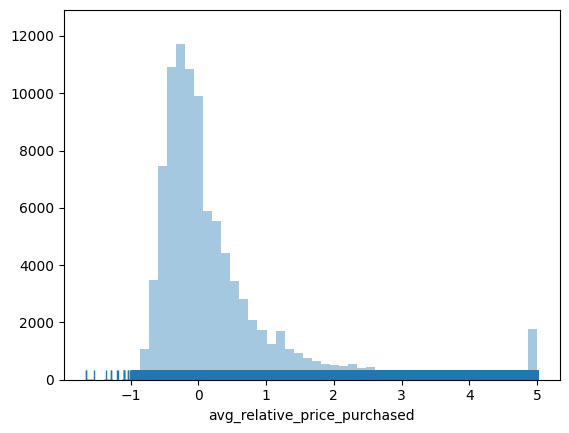

In [230]:
import seaborn as sns
sns.distplot(users_df.toPandas()['avg_relative_price_purchased'],kde=False,rug=True)

/var/folders/m1/2ckvnp7j54q8hjtqgnmldg180000gn/T/ipykernel_68551/2501710042.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users_df.toPandas()['average_price_purchased'],kde=False,rug=True)


<Axes: xlabel='average_price_purchased'>

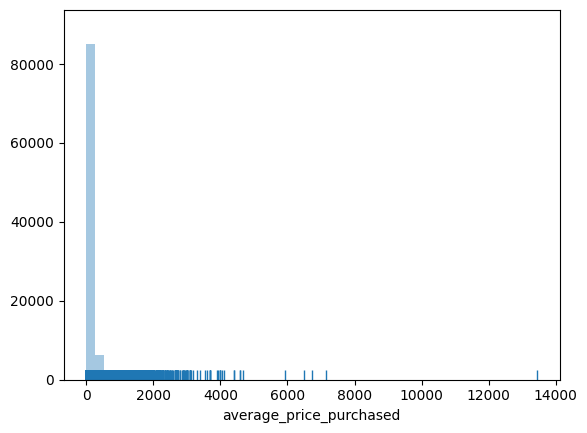

In [226]:
import seaborn as sns
sns.distplot(users_df.toPandas()['average_price_purchased'],kde=False,rug=True)

<Axes: >

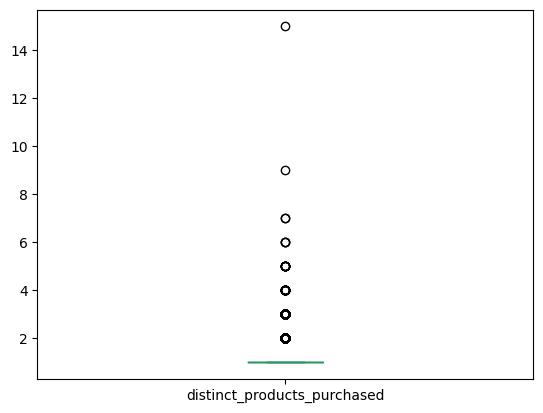

In [92]:
users_df.toPandas()['distinct_products_purchased'].plot.box()

<Axes: >

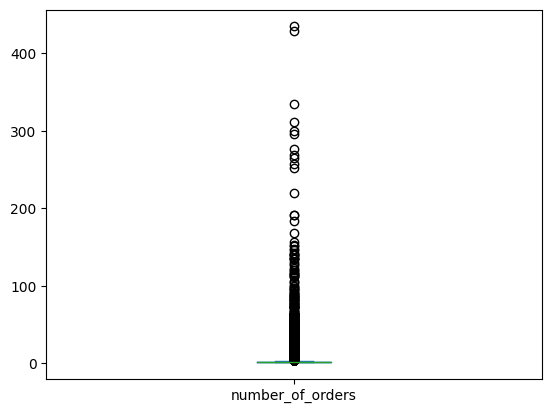

In [94]:
products.toPandas()['number_of_orders'].plot.box()

<Axes: >

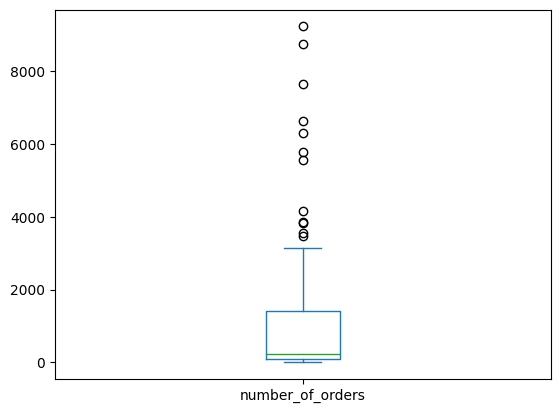

In [96]:
categories.toPandas()['number_of_orders'].plot.box()

In [98]:
categories.sort('number_of_orders', ascending=False).toPandas().head(20)

,product_category,number_of_products,number_of_orders,average_price
0,bed_bath_table,2815,9221,127.432899
1,health_beauty,2381,8738,159.032911
2,sport_leisure,2795,7637,148.009596
3,computers_accessories,1593,6626,179.480716
4,furniture_decor,2468,6284,128.163124
5,household_utilities,2250,5782,113.093378
6,watches_gifts,1305,5558,344.830966
7,telephony,1108,4158,87.235894
8,automobile,1845,3852,167.277680
9,toys,1375,3828,139.886916


## KMeans Clustering for Similar Users

In [134]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA,StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.clustering import KMeans, KMeansModel


In [102]:
categorical_columns = ['city', 'state', 'product_cat']

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]

# Fit and transform the data with StringIndexer
for indexer in indexers:
    users_df = indexer.fit(users_df).transform(users_df)

In [315]:
# # Create OneHotEncoder for indexed columns
# encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_ohe"]) for col in categorical_columns]

# # Fit and transform the data with OneHotEncoder
# for encoder in encoders:
#     users = encoder.fit(users).transform(users)

In [136]:
users_df.show()

+------------------+--------------------+-----+---------------------------+----------------+--------------------+----------+-----------------------+----------------------------+-------------------+-------------------+-----------+-------+----------+-----------+-----------------+
|customer_unique_id|                city|state|distinct_products_purchased|number_of_orders|         product_cat|product_id|average_price_purchased|avg_relative_price_purchased|         first_date|          last_date|mean rating|Recency|city_index|state_index|product_cat_index|
+------------------+--------------------+-----+---------------------------+----------------+--------------------+----------+-----------------------+----------------------------+-------------------+-------------------+-----------+-------+----------+-----------+-----------------+
|                26|            brasilia|   DF|                          1|               1|       sport_leisure|     26915|                  59.99|          -0.28

In [296]:
num_feature_cols=['average_price_purchased', 'avg_relative_price_purchased','distinct_products_purchased','product_cat_index','mean rating','Recency']
output_col='features'
# assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
# data = assembler.transform(users)


In [298]:
from pyspark.ml.feature import MinMaxScaler

# # Create a MinMaxScaler instance
# scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# # Fit the scaler to the data
# scalerModel = scaler.fit(data)

# # Transform the data
# data_df = scalerModel.transform(data)

In [300]:
# log_transformed_df = users_df.select([ f.log10 
#                                     (
#                                         f.col(colm) + 1
#                                     ).name(colm)    
#                                 for colm in num_feature_cols])

In [302]:
# Getting the numerical columns 
rfi_columns = ['distinct_products_purchased','average_price_purchased','Recency']
rfi_exprs = {x: "skewness" for x in rfi_columns}
rfi_exprs

{'distinct_products_purchased': 'skewness',
 'average_price_purchased': 'skewness',
 'Recency': 'skewness'}

In [304]:
rfi_skew = users_df[rfi_columns].groupby().agg(rfi_exprs).collect()[0].asDict()

rfi_skewness = pd.DataFrame.from_dict(rfi_skew, orient="index")
rfi_skewness.columns = ['Skewness']
rfi_skewness = rfi_skewness[rfi_skewness.notnull()]

In [306]:
rfi_skewness

,Skewness
skewness(Recency),0.448784
skewness(distinct_products_purchased),12.029535
skewness(average_price_purchased),9.650759


In [308]:
from pyspark.sql.functions import col, when
log_transformed_df = users_df
for colm in rfi_columns:
    log_transformed_df = log_transformed_df.withColumn(colm, f.log10(f.col(colm) + 1))
    

In [310]:
rfi_log1p_skew = log_transformed_df[rfi_columns].groupby().agg(rfi_exprs).collect()[0].asDict()

rfi_log1p_skewness = pd.DataFrame.from_dict(rfi_log1p_skew, orient="index")
rfi_log1p_skewness.columns = ['Skewness_after_log']
rfi_log1p_skewness = rfi_log1p_skewness[rfi_log1p_skewness.notnull()]
rfi_log1p_skewness

,Skewness_after_log
skewness(Recency),-1.082931
skewness(distinct_products_purchased),6.898334
skewness(average_price_purchased),0.293007


Text(0.5, 1.0, 'Log plus 1 transformation demonstrably reduces skew')

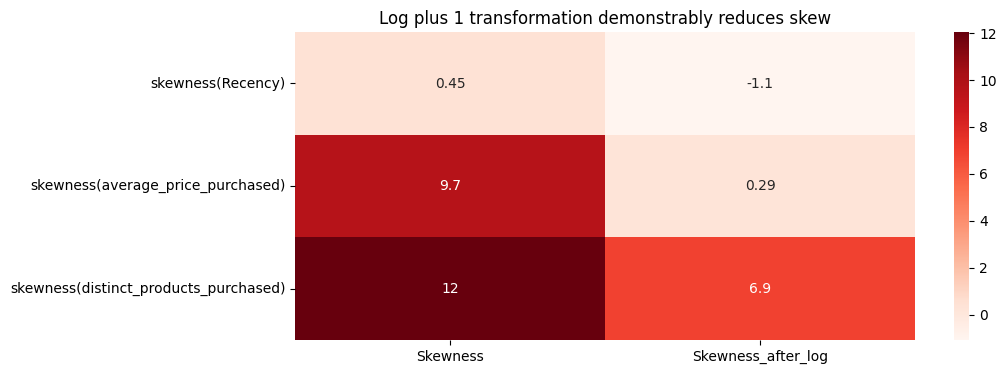

In [312]:
#Visualizing log1p transformed reducing skew

plt.figure(figsize=(10,4))
ax2 = sns.heatmap(rfi_skewness.join(rfi_log1p_skewness).sort_values(by='Skewness'), annot=True, cmap='Reds')
plt.title('Log plus 1 transformation demonstrably reduces skew')

In [314]:

# The columns need to be assembled into a single feature column before standard scaling them 
clust_assembler = VectorAssembler( inputCols = num_feature_cols, outputCol = 'unscaled_features' )

#scaler = MinMaxScaler(inputCol="unscaled_features", outputCol="scaled_features")
clust_scaler = StandardScaler( inputCol = 'unscaled_features', outputCol = 'scaled_features', withMean = True, withStd = True )

clust_pip = Pipeline(stages= [clust_assembler, scaler])
data_df=clust_pip.fit(log_transformed_df).transform(log_transformed_df)

In [316]:
data_df.show()

+------------------+--------------------+-----+---------------------------+----------------+--------------------+----------+-----------------------+----------------------------+-------------------+-------------------+-----------+------------------+----------+-----------+-----------------+--------------------+--------------------+
|customer_unique_id|                city|state|distinct_products_purchased|number_of_orders|         product_cat|product_id|average_price_purchased|avg_relative_price_purchased|         first_date|          last_date|mean rating|           Recency|city_index|state_index|product_cat_index|   unscaled_features|     scaled_features|
+------------------+--------------------+-----+---------------------------+----------------+--------------------+----------+-----------------------+----------------------------+-------------------+-------------------+-----------+------------------+----------+-----------+-----------------+--------------------+--------------------+
|   

In [188]:
#data_df=data_df.repartition(200)

In [318]:
 from pyspark.ml.feature import PCA
# pca = PCA(k=2, inputCol='scaled_features', outputCol='features_pca')
# pca_model = pca.fit(data_df)
# pca_result = pca_model.transform(data_df).select("userIntId", "pca_features")

In [320]:
# data_df=data_df.repartition(100)
# pca = PCA(k=3, inputCol="scaled_features", outputCol="pca_features")
# pca_model = pca.fit(data_df)
# pca_result = pca_model.transform(data_df).select("customer_unique_id", "pca_features")

In [322]:
# pca_result.show()

+------------------+--------------------+
|customer_unique_id|        pca_features|
+------------------+--------------------+
|             77422|[0.97147493911202...|
|             59488|[0.96972357896973...|
|             45839|[0.95198904305703...|
|              3538|[0.47450608740496...|
|              2189|[0.71924958697118...|
|             85918|[0.96167088847013...|
|             17213|[-0.0310943309551...|
|             80848|[0.97046466074746...|
|             74592|[0.94612215816568...|
|             58574|[-0.0279799582378...|
|             72098|[0.96597588344559...|
|             92248|[0.46932731244040...|
|             31046|[0.96288271142134...|
|             84436|[0.96937476532581...|
|             84542|[0.71940291775084...|
|             73128|[0.47038859709165...|
|             41203|[-0.0293385037204...|
|             73803|[0.47807567339191...|
|             38614|[0.72359420167127...|
|              4132|[0.95141569971106...|
+------------------+--------------

In [324]:
# max_k = len(feature_cols)  # Maximum number of components
# explained_variance_ratios = []

# for k in range(1, max_k + 1):
#     pca = PCA(k=k, inputCol="scaled_features", outputCol="pca_features")
#     model = pca.fit(data_df)
#     explained_variance = model.explainedVariance.toArray()
#     explained_variance_ratios.append(sum(explained_variance))

# # Plotting the cumulative explained variance
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, max_k + 1), explained_variance_ratios, marker='o')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs. Number of Components')
# plt.grid()
# plt.show()

In [326]:
#pca_result.show()

In [328]:
#pca_result=pca_result.repartition(100)

In [330]:
# #kmeans = KMeans(k=5, seed=42)
# kmeans = KMeans(k=5, seed=1, featuresCol='pca_features', predictionCol="cluster")
# model = kmeans.fit(pca_result)
# #model = kmeans.fit(data_df)

# # Make predictions
# predictions = model.transform(pca_result)

# # Evaluate the clustering results using WCSS
# evaluator = ClusteringEvaluator(featuresCol='pca_features', predictionCol="cluster", metricName="silhouette")
# wcss = evaluator.evaluate(predictions)
# print("Within-Cluster Sum of Squares (WCSS):", wcss)

Within-Cluster Sum of Squares (WCSS): 0.643244429156944


In [332]:
# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,15):    
    KMeans_mod = KMeans(k=i, seed=1, featuresCol="scaled_features", predictionCol="cluster")
    KMeans_fit = KMeans_mod.fit(data_df)  
    output = KMeans_fit.transform(data_df)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.7077761789562756
Silhouette Score: 0.5506763901023903
Silhouette Score: 0.39393178888335584
Silhouette Score: 0.5222343174179646
Silhouette Score: 0.44938295209128504
Silhouette Score: 0.3929960167586842
Silhouette Score: 0.37857167088110294


Silhouette Score: 0.38371421382955306
Silhouette Score: 0.4567213369806283
Silhouette Score: 0.43393888092965777
Silhouette Score: 0.3880124743924616


Silhouette Score: 0.36390128638130753


Silhouette Score: 0.40162912570016324


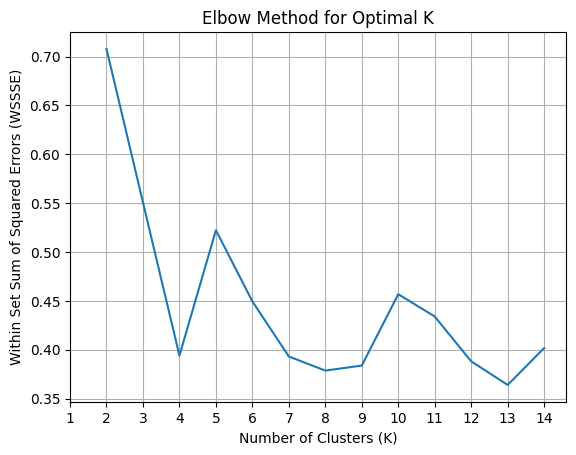

In [334]:
# Plotting WSSSE values
plt.plot(range(2, 15), wssse_values)
plt.xticks(range(1,15))
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [342]:
# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(featuresCol="pca_features", predictionCol="cluster", \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,15):    
    KMeans_mod = KMeans(k=i, seed=1, featuresCol="pca_features", predictionCol="cluster")
    KMeans_fit = KMeans_mod.fit(pca_result)  
    output = KMeans_fit.transform(pca_result)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.7758911699218892
Silhouette Score: 0.6573667643130859
Silhouette Score: 0.6043804062967721
Silhouette Score: 0.643244429156944
Silhouette Score: 0.6357593757349694
Silhouette Score: 0.54496947546039


Silhouette Score: 0.5122654989896966
Silhouette Score: 0.48091721162671236
Silhouette Score: 0.5571335667827353
Silhouette Score: 0.5002206091853906
Silhouette Score: 0.5564231951852873


Silhouette Score: 0.5172436398946558


Silhouette Score: 0.5081956444197999


 We notice the elbow point at k=7

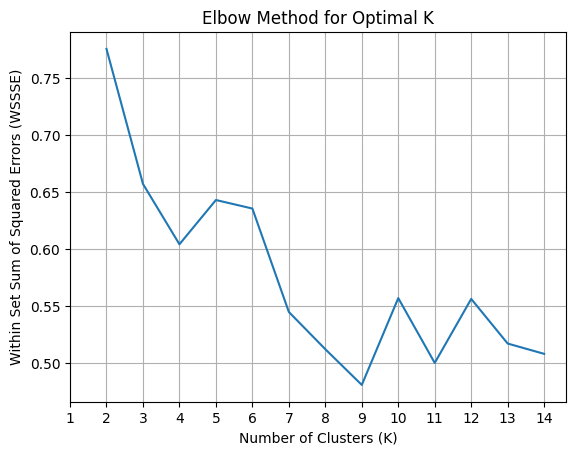

In [344]:
# Plotting WSSSE values
plt.plot(range(2, 15), wssse_values)
plt.xticks(range(1,15))
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [346]:
KMeans_mod = KMeans(k=7, seed=1, featuresCol="scaled_features", predictionCol="cluster")
KMeans_fit = KMeans_mod.fit(data_df) 

In [350]:
output = KMeans_fit.transform(data_df)
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
score = evaluator.evaluate(output) 
print('Within-Cluster Sum of Squares (WCSS):',score)
# Printing cluster centers 
centers = model.clusterCenters() 
print("Cluster Centers: ") 
for center in centers: 
    print(center)

Within-Cluster Sum of Squares (WCSS): 0.3929960167586842
Cluster Centers: 
[0.02556893 0.48587878 0.0334558 ]
[8.74602099e-01 9.24673343e-01 8.14613651e-04]
[ 0.96997463  0.44315392 -0.00649035]
[0.89797601 0.48066212 0.38735224]
[0.63896186 0.4398546  0.00243031]


In [352]:
output.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 5977|
|      6| 4448|
|      3|21264|
|      5|26422|
|      4|11696|
|      2|11671|
|      0|13242|
+-------+-----+



In [356]:
user_cluster=output.select('customer_unique_id', 'cluster')

In [358]:
user_cluster.show()

+------------------+-------+
|customer_unique_id|cluster|
+------------------+-------+
|             77422|      2|
|             59488|      6|
|             45839|      1|
|              3538|      3|
|              2189|      3|
|             85918|      5|
|             17213|      0|
|             80848|      2|
|             74592|      1|
|             58574|      0|
|             72098|      5|
|             92248|      3|
|             31046|      1|
|             84436|      5|
|             84542|      3|
|             73128|      3|
|             41203|      0|
|             73803|      3|
|             38614|      3|
|              4132|      1|
+------------------+-------+
only showing top 20 rows



In [392]:
user_clust=users_df.join(user_cluster,'customer_unique_id','left')

In [394]:
user_cluster_data=user_clust.groupBy('cluster').agg(mode('product_cat').alias('most ordered product category'), mode('product_id').alias('top_product'),mean('average_price_purchased').alias('average_price_ordered'),countDistinct('customer_unique_id').alias('number_of_customers'))

In [396]:
user_cluster_data.show()

+-------+-----------------------------+-----------+---------------------+-------------------+
|cluster|most ordered product category|top_product|average_price_ordered|number_of_customers|
+-------+-----------------------------+-----------+---------------------+-------------------+
|      1|                health_beauty|      23182|    571.0373448218115|               5977|
|      6|              books_technical|       9987|   159.96239246103158|               4448|
|      3|               bed_bath_table|      18989|    97.35297402532733|              21264|
|      5|               bed_bath_table|      21273|   101.33287083814857|              26422|
|      4|                health_beauty|       3285|    98.19267310456372|              11696|
|      2|                    perfumery|       8276|    81.18311797047008|              11671|
|      0|               bed_bath_table|      18989|   158.88086414438717|              13242|
+-------+-----------------------------+-----------+---------

In [398]:
user_cluster_info=user_clust.toPandas()

In [399]:
user_cluster_info.to_csv('User_clusters_upd.csv')

In [402]:
user_cluster_info.columns

Index(['customer_unique_id', 'city', 'state', 'distinct_products_purchased',
       'number_of_orders', 'product_cat', 'product_id',
       'average_price_purchased', 'avg_relative_price_purchased', 'first_date',
       'last_date', 'mean rating', 'Recency', 'city_index', 'state_index',
       'product_cat_index', 'cluster'],
      dtype='object')

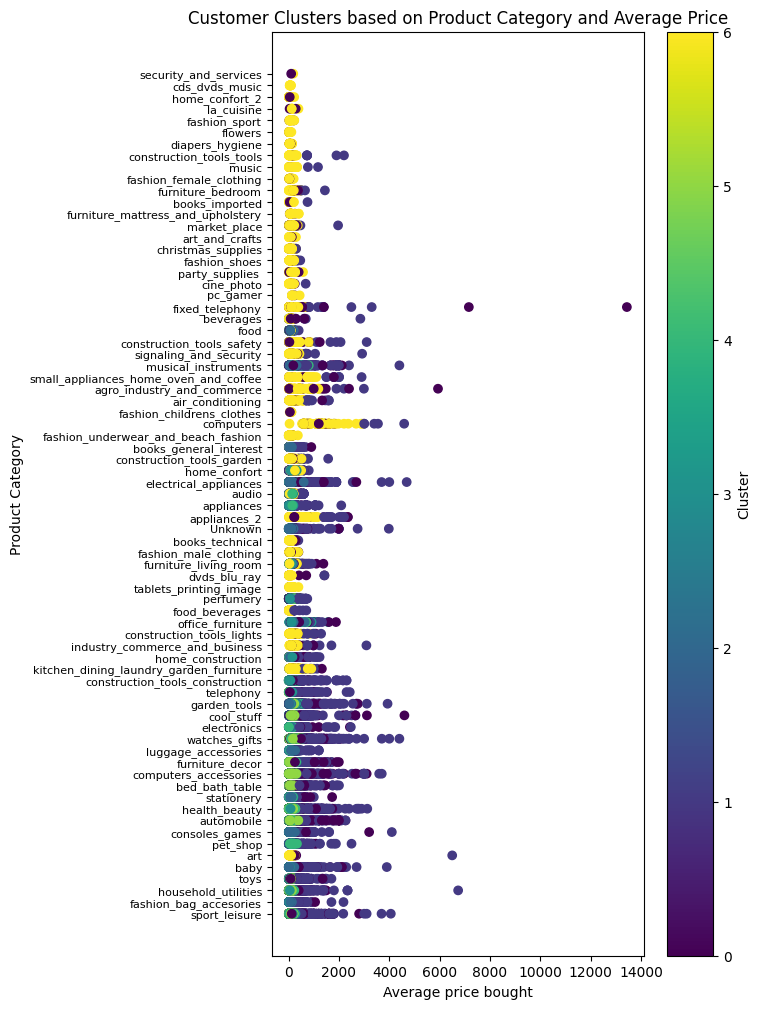

In [426]:
# Converting to Pandas DataFrame
clustered_data_pd = user_clust.toPandas()
plt.figure(figsize=(6, 12)) 
# Visualizing the results
plt.scatter(clustered_data_pd['average_price_purchased'],clustered_data_pd["product_cat"], c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("Average price bought")
plt.ylabel("Product Category")
plt.title("Customer Clusters based on Product Category and Average Price")
plt.colorbar().set_label("Cluster")
plt.yticks(rotation=0, fontsize=8)
#plt.xticks(rotation=90)
plt.show()

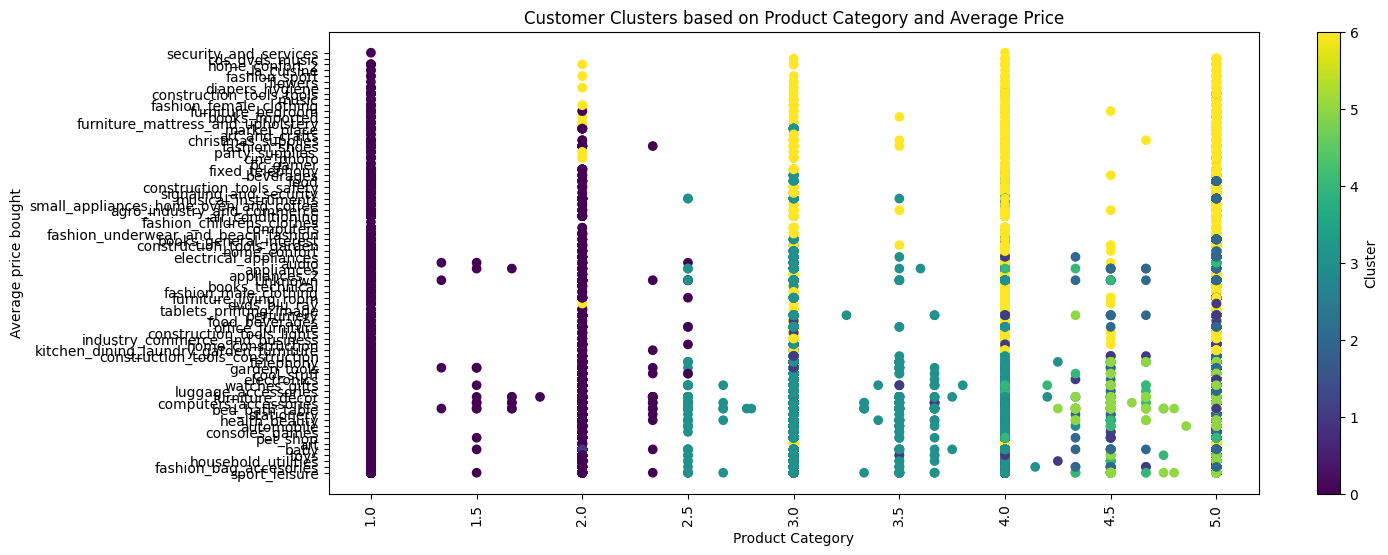

In [410]:
# Converting to Pandas DataFrame
clustered_data_pd = user_clust.toPandas()
plt.figure(figsize=(15, 6)) 
# Visualizing the results
plt.scatter(clustered_data_pd["mean rating"],clustered_data_pd['product_cat'], c=clustered_data_pd["cluster"], cmap='viridis')
plt.ylabel("Average price bought")
plt.xlabel("Product Category")
plt.title("Customer Clusters based on Product Category and Average Price")
plt.colorbar().set_label("Cluster")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# from pyspark.sql.functions import broadcast

# # Get unique clusters
# clusters = user_clust.select("cluster").distinct().collect()
# cluster_recommendations = []

# for cluster in clusters:
#     cluster_id = cluster["cluster"]
#     print(f"Processing cluster {cluster_id}")

#     # Filter users in the current cluster
#     cluster_users = user_data.filter(col("cluster") == cluster_id).select("user_id")

#     # Filter interaction data for users in the current cluster
#     cluster_interactions = interaction_data.join(broadcast(cluster_users), "user_id")

#     # Train ALS model on the filtered interaction data
#     als = ALS(maxIter=10, regParam=0.01, userCol="user_id", itemCol="product_id", ratingCol="rating", coldStartStrategy="drop")
#     als_model = als.fit(cluster_interactions)

#     # Make recommendations for users in the current cluster
#     cluster_user_recommendations = als_model.recommendForAllUsers(10)
#     cluster_recommendations.append(cluster_user_recommendations)

# # Combine recommendations from all clusters
# all_recommendations = cluster_recommendations[0]
# for rec in cluster_recommendations[1:]:
#     all_recommendations = all_recommendations.union(rec)

# # Show combined recommendations
# all_recommendations.show()

### Approach 2

In [139]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA,StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.clustering import KMeans, KMeansModel

In [135]:
categorical_columns = ['city', 'state', 'product_cat']

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]

# Fit and transform the data with StringIndexer
for indexer in indexers:
    users_df = indexer.fit(users_df).transform(users_df)

In [141]:
from sklearn import preprocessing
user_data=users_df.toPandas()
#Num_features=user_data.select_dtypes(include=[np.number]).columns
Num_features=['average_price_purchased',	'avg_relative_price_purchased','Recency', 'number_of_orders', 'distinct_products_purchased']
user_data[Num_features]=preprocessing.MinMaxScaler().fit_transform(user_data[Num_features])
user_data.head()

,customer_unique_id,city,state,distinct_products_purchased,number_of_orders,product_cat,product_id,average_price_purchased,avg_relative_price_purchased,first_date,last_date,mean rating,Recency,city_index,state_index,product_cat_index
0,26,brasilia,DF,0.0,0.0,sport_leisure,26915,0.004401,0.206775,2017-01-21 21:58:35,2017-01-21 21:58:35,4.0,0.809066,3.0,7.0,2.0
1,27,goianesia do para,PA,0.0,0.0,computers_accessories,260,0.019953,0.421754,2017-04-24 13:36:48,2017-04-24 13:36:48,3.0,0.681319,1981.0,12.0,3.0
2,28,santo andre,SP,0.0,0.0,luggage_accessories,15176,0.012909,0.370108,2017-06-28 11:08:38,2017-06-28 11:08:38,5.0,0.592033,11.0,0.0,21.0
3,31,sao paulo,SP,0.0,0.0,health_beauty,6507,0.006485,0.244965,2018-01-18 20:49:36,2018-01-18 20:49:36,5.0,0.311813,0.0,0.0,1.0
4,34,jarinu,SP,0.0,0.0,bed_bath_table,19756,0.003501,0.197209,2017-04-19 11:32:09,2017-04-19 11:32:09,3.0,0.688187,553.0,0.0,0.0


In [143]:
user_data.drop(columns=['product_cat','city','state'],inplace=True)

In [145]:
# from sklearn.preprocessing import LabelEncoder
# categorical_columns = ['city', 'state', 'product_cat']
# label_encoder = LabelEncoder()
# for col in category_columns:
#     user_data[col] = label_encoder.fit_transform(user_data[col])

In [175]:
# #Hopkins Statistic is a way of measuring the cluster tendency of a data set.
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
# def hopkins(X):
#     d = X.shape[1]
#     #d = len(vars) # columns
#     n = len(X) # rows
#     m = int(0.1 * n) # heuristic from article [1]
#     nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
#     rand_X = sample(range(0, n, 1), m)
 
#     ujd = []
#     wjd = []
#     for j in range(0, m):
#         u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
#         ujd.append(u_dist[0][1])
#         w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
#         wjd.append(w_dist[0][1])
 
#     H = sum(ujd) / (sum(ujd) + sum(wjd))
#     if isnan(H):
#         print(ujd, wjd)
#         H = 0
 
#     return H

In [176]:
from random import sample
from numpy.random import uniform
def hopkins_statistic(X):
    
    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H
    
    

In [179]:
user_data.columns

Index(['customer_unique_id', 'distinct_products_purchased', 'number_of_orders',
       'product_id', 'average_price_purchased', 'avg_relative_price_purchased',
       'first_date', 'last_date', 'mean rating', 'Recency', 'city_index',
       'state_index', 'product_cat_index'],
      dtype='object')

In [181]:
#Use a random sample of Data for faster computation
Data = user_data.sample(20000,random_state=41)
Data.head()
#Resetting the indexs
#Data=Data.reset_index(drop=True)

,customer_unique_id,distinct_products_purchased,number_of_orders,product_id,average_price_purchased,avg_relative_price_purchased,first_date,last_date,mean rating,Recency,city_index,state_index,product_cat_index
70149,94647,0.0,0.0,15228,0.015488,0.259955,2018-04-18 18:48:21,2018-04-18 18:48:21,5.0,0.188187,329.0,1.0,6.0
73979,30986,0.0,0.0,2819,0.004401,0.201673,2017-07-13 11:01:28,2017-07-13 11:01:28,5.0,0.571429,4.0,4.0,9.0
38520,30500,0.0,0.0,20366,0.008665,0.294799,2018-01-21 21:18:10,2018-01-21 21:18:10,4.0,0.307692,545.0,8.0,8.0
39478,38101,0.0,0.0,10425,0.002839,0.202724,2018-06-18 09:37:42,2018-06-18 09:37:42,5.0,0.104396,8.0,0.0,43.0
69621,90600,0.0,0.0,14302,0.016977,0.300647,2017-11-06 12:34:20,2017-11-06 12:34:20,4.0,0.412088,1.0,1.0,35.0


In [183]:
Data=Data.reset_index(drop=True)

In [185]:
categorical_columns_ind = ['city_index', 'state_index', 'product_cat_index']
for cat in categorical_columns_ind:
    Data[cat]=Data[cat].astype(object)

In [187]:
#Checking whether data can be clustered
Num_features =Data.select_dtypes(include=[np.number]).columns
Num_features
#hopkins(Data[Num_features])

Index(['customer_unique_id', 'distinct_products_purchased', 'number_of_orders',
       'product_id', 'average_price_purchased', 'avg_relative_price_purchased',
       'mean rating', 'Recency'],
      dtype='object')

In [189]:
hopkins_statistic(Data[Num_features])

np.float64(0.4982243340858137)

In [191]:
l = [] #list to hold values for each call
for i in range(20):
    H=hopkins_statistic(Data[Num_features])
    l.append(H)
#print average value:
np.mean(l)
    
    

np.float64(0.5036939227745837)

In [193]:
#Selection of variables for PCA
Data_pca= Data[['average_price_purchased','avg_relative_price_purchased','product_cat_index','Recency', 'city_index']]
print (Data_pca.dtypes)

average_price_purchased         float64
avg_relative_price_purchased    float64
product_cat_index                object
Recency                         float64
city_index                       object
dtype: object


In [195]:
#Principal Component
from sklearn.decomposition import PCA
pca = PCA(n_components=3, whiten=True)
Num_features=Data_pca.select_dtypes(include=[np.number]).columns
x=Data_pca[Num_features]
principalComponents = pca.fit_transform(x)

# Cumulative Explained Variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

[np.float64(0.6320999183948638), np.float64(0.9979889411442127), np.float64(1.0)]


In [197]:
#Principal Components converted to a Data frame
principalDf  = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.shape

(20000, 3)

In [225]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca[['product_cat_index']]], axis = 1)
finalDf_Cat.head(5)

,principal component 1,principal component 2,principal component 3,product_cat_index
0,-0.693883,-0.196666,0.640899,6.0
1,1.114818,-0.593897,0.051336,9.0
2,-0.126654,0.006670,-0.141977,8.0
3,-1.093710,-0.550323,-0.071768,43.0
4,0.367438,0.038178,0.515021,35.0


In [227]:
import random
from kmodes.kprototypes import KPrototypes

In [ ]:
finalDf_Cat['product_cat_index']=finalDf_Cat['product_cat_index'].astype(str)
X = finalDf_Cat.to_numpy()
kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) 
kproto.fit_predict(X, categorical=[3])

In [ ]:
#Choosing optimal K value
cost = []
finalDf_Cat['product_cat_index']=finalDf_Cat['product_cat_index'].astype(str)
X = finalDf_Cat.to_numpy()
for num_clusters in list(range(2,10)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=[3])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [257]:
Data_clust=Data[['customer_unique_id',	'distinct_products_purchased',	'average_price_purchased','Recency','product_cat_index','city_index']]
categorical_index=[4,5]

In [261]:
test_model = KPrototypes(n_clusters=5, init='Huang', random_state=42,max_iter=15,n_init=50)
test_model.fit_predict(Data_clust, categorical=categorical_index)
print(test_model.cost_)

597669313601.3553


In [253]:
# Function for plotting elbow curve
def plot_elbow_curve(start, end, data):
    no_of_clusters = list(range(start, end+1))
    cost_values = []
    
    for k in no_of_clusters:
        test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
        test_model.fit_predict(data, categorical=categorical_index)
        cost_values.append(test_model.cost_)
        
    sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No of clusters', fontsize=14)
    ax.set_ylabel('Cost', fontsize=14)
    ax.set(xlim=(start-0.1, end+0.1))
    plt.plot();
    
# Plotting elbow curve for k=2 to k=10
plot_elbow_curve(2,5,Data_clust)

KeyboardInterrupt: 

## Train Recommendation Model using ALS

In [95]:
input_df=pd.read_csv('df_final.csv')

In [182]:
input_df.columns

Index(['total_value', 'price', 'review_score', 'order_item_quantity',
       'freight_value', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_id', 'customer_id', 'order_status', 'customer_unique_id',
       'customer_city', 'customer_state', 'review_id', 'product_id',
       'seller_id', 'product_category', 'seller_city', 'seller_state',
       'order_purchased_at', 'order_approved_at',
       'order_estimated_delivery_date'],
      dtype='object')

In [184]:
# from sklearn.preprocessing import LabelEncoder

# u_transf = LabelEncoder()
# item_transf = LabelEncoder()
# # encoding
# input_data['customer_unique_id'] = u_transf.fit_transform(input_data['customer_unique_id'])
# input_data['product_id'] = item_transf.fit_transform(input_data['product_id'])

In [186]:
def reduce_sparsity(df, min_items_per_user, min_user_per_item, user_col='customer_unique_id', item_col='product_id'):
    good_users = df[user_col].value_counts()[df[user_col].value_counts() > min_items_per_user].index
    df = df[df[user_col].isin(good_users)]

    good_items = df[item_col].value_counts()[df[item_col].value_counts() > min_user_per_item].index
    df = df[df[item_col].isin(good_items)].reset_index(drop=1)

    return df

In [188]:
##%%
df_final=reduce_sparsity(input_df, 1, 10)
df_final.shape

(8884, 25)

In [190]:

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['customer_unique_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['product_id'].nunique())

The number of observations in the final data = 8884
Number of unique USERS in the final data =  3805
Number of unique PRODUCTS in the final data =  364


In [192]:
final_ratings_matrix = df_final.groupby(['customer_unique_id', 'product_id'])['review_score'].mean().unstack(fill_value=0)


print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

# Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

# Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

# Density of ratings
density = (given_num_of_ratings / possible_num_of_ratings)
density *= 100
print('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (3805, 364)
given_num_of_ratings =  4254
possible_num_of_ratings =  1385020
density: 0.31%


product_id,00ba6d766f0b1d7b78a5ce3e1e033263,0152f69b6cf919bcdaf117aa8c43e5a2,017692475c1c954ff597feda05131d73,03e1c946c0ddfc58724ff262aef08dff,0449db5eede617c5fd413071d582f038,04c4a4b9c924494fcf82e0fba966f955,054515fd15bc1a2029f10de97ffa9120,0554911df28fda9fd668ce5ba5949695,060c17562f97e5bb60bc0dfa4dd5b3f2,060cb19345d90064d1015407193c233d,...,f819f0c84a64f02d3a5606ca95edd272,f8ea5fcf9c628485e01b9c3cf52728c2,f919da4f716dc149cef4551a322001fd,fa126ff62aae83e37857ad495641c878,fb55982be901439613a95940feefd9ee,fb783e3e545937820b57fe539b2c5a6c,fbc1488c1a1e72ba175f53ab29a248e8,fbce4c4cb307679d89a3bf3d3bb353b9,fc1d8637c0268af3db482c14b7ef8e75,fe6a9515d655fa7936b8a7c841039f34
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
001147e649a7b1afd577e873841632dd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001926cef41060fae572e2e7b30bd2a4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002ae492472e45ad6ebeb7a625409392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003e2af81ea3c72fbdd093f07724a4de,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004177f7bf62929186b32c7fdaa6157b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
user_ratings=final_ratings_matrix.stack().reset_index(name='rating')

In [196]:
user_ratings

,customer_unique_id,product_id,rating
0,001147e649a7b1afd577e873841632dd,00ba6d766f0b1d7b78a5ce3e1e033263,0.0
1,001147e649a7b1afd577e873841632dd,0152f69b6cf919bcdaf117aa8c43e5a2,0.0
2,001147e649a7b1afd577e873841632dd,017692475c1c954ff597feda05131d73,0.0
3,001147e649a7b1afd577e873841632dd,03e1c946c0ddfc58724ff262aef08dff,0.0
4,001147e649a7b1afd577e873841632dd,0449db5eede617c5fd413071d582f038,0.0
...,...,...,...
1385015,ffad6a7a0e13be3dfd9de96a81b77c9e,fb783e3e545937820b57fe539b2c5a6c,0.0
1385016,ffad6a7a0e13be3dfd9de96a81b77c9e,fbc1488c1a1e72ba175f53ab29a248e8,0.0
1385017,ffad6a7a0e13be3dfd9de96a81b77c9e,fbce4c4cb307679d89a3bf3d3bb353b9,0.0
1385018,ffad6a7a0e13be3dfd9de96a81b77c9e,fc1d8637c0268af3db482c14b7ef8e75,0.0


In [198]:
df_data=spark.createDataFrame(user_ratings)

In [199]:
df_data.show(5)

+--------------------+--------------------+------+
|  customer_unique_id|          product_id|rating|
+--------------------+--------------------+------+
|001147e649a7b1afd...|00ba6d766f0b1d7b7...|   0.0|
|001147e649a7b1afd...|0152f69b6cf919bcd...|   0.0|
|001147e649a7b1afd...|017692475c1c954ff...|   0.0|
|001147e649a7b1afd...|03e1c946c0ddfc587...|   0.0|
|001147e649a7b1afd...|0449db5eede617c5f...|   0.0|
+--------------------+--------------------+------+
only showing top 5 rows



In [202]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(df_data.columns)-set(['rating'])) ]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_data).transform(df_data)
transformed.show()

+--------------------+--------------------+------+------------------------+----------------+
|  customer_unique_id|          product_id|rating|customer_unique_id_index|product_id_index|
+--------------------+--------------------+------+------------------------+----------------+
|001147e649a7b1afd...|00ba6d766f0b1d7b7...|   0.0|                     0.0|             0.0|
|001147e649a7b1afd...|0152f69b6cf919bcd...|   0.0|                     0.0|             1.0|
|001147e649a7b1afd...|017692475c1c954ff...|   0.0|                     0.0|             2.0|
|001147e649a7b1afd...|03e1c946c0ddfc587...|   0.0|                     0.0|             3.0|
|001147e649a7b1afd...|0449db5eede617c5f...|   0.0|                     0.0|             4.0|
|001147e649a7b1afd...|04c4a4b9c924494fc...|   0.0|                     0.0|             5.0|
|001147e649a7b1afd...|054515fd15bc1a202...|   0.0|                     0.0|             6.0|
|001147e649a7b1afd...|0554911df28fda9fd...|   0.0|                    

In [204]:
transformed.groupBy("customer_unique_id").count().orderBy("count", ascending=False).show(10)
transformed.groupBy("product_id").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|  customer_unique_id|count|
+--------------------+-----+
|14a188558af6cd5bc...|  364|
|1d2435aa3b858d45c...|  364|
|0cf0c4ba8023930f2...|  364|
|20a5257c01689ac69...|  364|
|068b769463d8f4148...|  364|
|0fb360a422d2297dc...|  364|
|200d8b1f16d0cc960...|  364|
|208fe9aa6033a7741...|  364|
|20ae758fb6688386d...|  364|
|078401292a38d006a...|  364|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|          product_id|count|
+--------------------+-----+
|35bc6c77029697004...| 3805|
|a3daee3915d4fb983...| 3805|
|64fb265487de22386...| 3805|
|53b36df67ebb7c415...| 3805|
|d5991653e037ccb7a...| 3805|
|36f60d45225e60c7d...| 3805|
|d3c044bd42d84a79e...| 3805|
|130482add9fd75ccb...| 3805|
|473795a355d29305c...| 3805|
|70906e04da1eebf3d...| 3805|
+--------------------+-----+
only showing top 10 rows



In [206]:
(training,test)=transformed.randomSplit([0.8, 0.2])

In [208]:
training = training.repartition(200, "customer_unique_id")

In [210]:
# dfs_train, dfs_test = spark_random_split(df_data, ratio=0.75, seed=42)

In [212]:
# als = ALS(
#     maxIter=MAX_ITER, 
#     rank=RANK,
#     regParam=REG_PARAM, 
#     userCol=COL_USER, 
#     itemCol=COL_ITEM, 
#     ratingCol=COL_RATING, 
#     coldStartStrategy="drop"
# )

# model = als.fit(dfs_train)

### Cross Validation for Model Hyperparameters Tuning

In [263]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

def cross_validate_als(interaction_matrix):
    
    # Define the ALS model
    als = ALS(userCol="customer_unique_id_index",itemCol="product_id_index",ratingCol="rating", 
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=False)

    # Define the parameter grid for hyperparameter tuning
    param_grid = ParamGridBuilder().addGrid(als.rank, [1, 20, 30])\
    .addGrid(als.regParam, [0.01, 0.05, 0.1]) \
    .addGrid(als.maxIter, [10, 20])\
    .build()
        
    # Define the evaluator for computing the evaluation metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

    # Define the cross-validator for performing 5-fold cross-validation
    cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=False)

    # Define the pipeline for fitting the model and evaluating it
    pipeline = Pipeline(stages=[cv])

    # Fit the pipeline on the data and evaluate the model
    model = pipeline.fit(interaction_matrix)
    
    return model


In [265]:
model = cross_validate_als(training)

# Model with the lowest RMSE value 
#bestModel = model.stages[0].bestModel


In [267]:
best_model = model.stages[0].bestModel
print('rank: ', best_model.rank)
print('MaxIter: ', best_model._java_obj.parent().getMaxIter())
print('RegParam: ', best_model._java_obj.parent().getRegParam())
print('alpha: ',  bestModel._java_obj.parent().getAlpha())

rank:  30
MaxIter:  10
RegParam:  0.05
alpha:  0.0


In [269]:

# Make predictions
predictions = bestModel.transform(training)
predictions.show()


+--------------------+--------------------+------+------------------------+----------------+-------------+
|  customer_unique_id|          product_id|rating|customer_unique_id_index|product_id_index|   prediction|
+--------------------+--------------------+------+------------------------+----------------+-------------+
|6e62ba22142e89bac...|0152f69b6cf919bcd...|   0.0|                  1591.0|             1.0|1.1131893E-15|
|6e62ba22142e89bac...|017692475c1c954ff...|   0.0|                  1591.0|             2.0|          0.0|
|6e62ba22142e89bac...|03e1c946c0ddfc587...|   0.0|                  1591.0|             3.0|          0.0|
|6e62ba22142e89bac...|0449db5eede617c5f...|   0.0|                  1591.0|             4.0|          0.0|
|6e62ba22142e89bac...|04c4a4b9c924494fc...|   0.0|                  1591.0|             5.0|          0.0|
|6e62ba22142e89bac...|054515fd15bc1a202...|   0.0|                  1591.0|             6.0|          0.0|
|6e62ba22142e89bac...|060c17562f97e5b

In [271]:
# Calculate RMSE and MAE metrics
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print(' rmse:' + str(rmse) + ' mae:' + str(mae))


 rmse:0.2252487336756801 mae:0.012192261015594922


In [321]:
training_df=training.select(col("customer_unique_id_index"),col("product_id_index"), col("rating"))
train, validation=training_df.randomSplit([0.7,0.3], seed=99)

In [323]:
def train_and_evaluate_als(training, validation, rank, regParam, maxIter):
    als = ALS(maxIter=maxIter, rank=rank, regParam=regParam, userCol="customer_unique_id_index",itemCol="product_id_index",ratingCol="rating", 
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=False)
    model = als.fit(training)

    predictions = model.transform(validation)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    return rmse

In [325]:
iterations = [2, 5, 10, 15, 20]
rmse_values = []
for iter in iterations:
    rmse = train_and_evaluate_als(training, validation, rank=30, regParam=0.05, maxIter=iter)
    rmse_values.append(rmse)

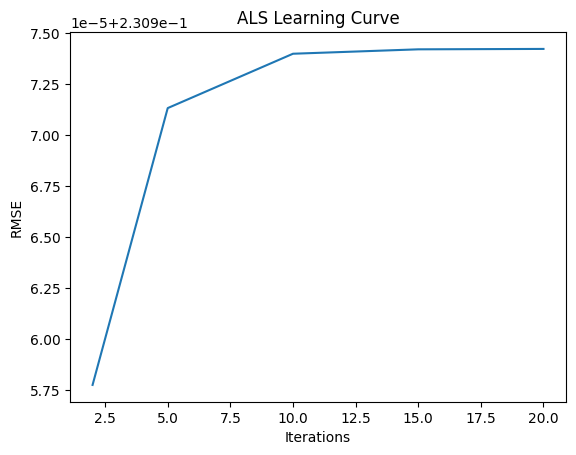

In [327]:
plt.plot(iterations, rmse_values)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("ALS Learning Curve")
plt.show()

The graph shows that RMSE is increasing with number of iterations, and the model is overfitting.

### Training Model

In [273]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

#def simple_als(interaction_matrix):
    
    # Train-test split
    #(train, test) = interaction_matrix.randomSplit([0.8, 0.2])
    
    # Initialize the model with the optimized parameters
als = ALS(userCol="customer_unique_id_index",itemCol="product_id_index",ratingCol="rating", maxIter=10,
          alpha=0.0, regParam=0.05, rank=30, implicitPrefs=True, 
          nonnegative=True, coldStartStrategy='drop')

# Fit the ALS model on the ratings data
model = als.fit(training)

# Make predictions
predictions = best_model.transform(test)

# Calculate the RMSE and MAE metrics
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print('test rmse:' + str(rmse) + ' mae:' + str(mae))




test rmse:0.23140925140413796 mae:0.012268902783183091


In [227]:
userRecs = model.recommendForAllUsers(100) 
userRecs.show(10)

+------------------------+--------------------+
|customer_unique_id_index|     recommendations|
+------------------------+--------------------+
|                      26|[{99, 1.22042E-4}...|
|                      27|[{99, 5.904459E-9...|
|                      28|[{99, 4.9281876E-...|
|                      31|[{99, 1.2435938E-...|
|                      34|[{214, 1.7780683E...|
|                      44|[{84, 2.318453E-9...|
|                      53|[{122, 0.90258265...|
|                      65|[{363, 0.0}, {362...|
|                      76|[{36, 0.001375694...|
|                      78|[{36, 5.123226E-1...|
+------------------------+--------------------+
only showing top 10 rows



In [275]:
# 3 random users
user_subset = [85, 170, 200]

# Recommend top 500 products for the users
recommendations = spark.createDataFrame([(user, 0) for user in user_subset], ['customer_unique_id_index', 'product_id_index'])
recommendations = model.recommendForUserSubset(recommendations, 5)

In [277]:
recommendations.show()

+------------------------+--------------------+
|customer_unique_id_index|     recommendations|
+------------------------+--------------------+
|                      85|[{296, 0.24676909...|
|                     200|[{117, 4.0225426E...|
|                     170|[{97, 0.9527734},...|
+------------------------+--------------------+



In [279]:

recs_for_user_1 = spark.createDataFrame(recommendations.collect()[1][1])
recs_for_user_1.show()

+----------------+--------------------+
|product_id_index|              rating|
+----------------+--------------------+
|             117|4.022542634629644...|
|             347|3.083144838456064...|
|             243|1.883283584902528...|
|              24|3.774537162826163...|
|             232|1.071112365025328...|
+----------------+--------------------+



In [ ]:
# def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):
   
#     recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
    
#     user_avg_relative_price = users.filter(col('user_id') == user_id)['user_id', 'avg_relative_price_purchased'].collect()[0][1]

    
#     # Scale CF rating score, ranges from 0 to 2
#     recs = recs.withColumn('rating', col('rating') / 2)
    
#     # Scale purchase_per_view rate, ranges from 0 to 0.075
#     recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
#     # Scale relative price value, ranges from -5 to 5
#     recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
#     # Scale users average relative price value, ranges from -1 to 1
#     user_avg_relative_price = (user_avg_relative_price + 1) / 2
    
    
#     # Calculate the recommendation scores
#     recs = recs.withColumn('recommendation_score', ((recs['rating'] * coef_als_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(user_avg_relative_price + coef_spending_booster - recs['relative_price']) * coef_spending_habit) / (coef_als_score + coef_conversion_rate + coef_spending_habit)) 

    
#     # Scale back CF rating score, ranges from 0 to 2
#     recs = recs.withColumn('rating', col('rating') * 2)

#     # Scale back purchase_per_view rate, ranges from 0 to 0.075
#     recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
#     # Scale back relative price value, ranges from -1 to 1
#     recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)

#     # Scale back average relative price value, ranges from -5 to 5
#     user_avg_relative_price = user_avg_relative_price * 10 - 5
    
#     return recs

### Evaluation

In [285]:
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql.functions import col, collect_list

# Prepare the input for RankingMetrics
user_ground_truth = test.groupby('customer_unique_id_index').agg(collect_list('product_id_index').alias('ground_truth_items'))
user_train_items = training.groupby('customer_unique_id_index').agg(collect_list('product_id_index').alias('train_items'))

# Join the recommendations and ground truth data on the user ID
user_eval = userRecs.join(user_ground_truth, on='customer_unique_id_index').join(user_train_items, on='customer_unique_id_index') \
    .select('customer_unique_id_index', 'recommendations.product_id_index', 'ground_truth_items', 'train_items', 'recommendations.rating')
user_eval = user_eval.toPandas()
user_eval['itemIndex_filtered'] = user_eval.apply(lambda x:[b for (b,z) in zip(x.product_id_index, x.rating) if b not in x.train_items], axis=1)
user_eval['rating_filtered'] = user_eval.apply(lambda x:[z for (b,z) in zip(x.product_id_index, x.rating) if b not in x.train_items], axis=1)

In [293]:
user_eval.head()

,customer_unique_id_index,product_id_index,ground_truth_items,train_items,rating,itemIndex_filtered,rating_filtered,precision
0,496,"[363, 362, 361, 360, 359, 358, 357, 356, 355, ...","[3.0, 13.0, 21.0, 33.0, 36.0, 46.0, 48.0, 52.0...","[0.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[361, 359, 358, 353, 339, 329, 315, 306, 299, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.542117
1,596,"[363, 362, 361, 360, 359, 358, 357, 356, 355, ...","[1.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 25.0, 3...","[0.0, 2.0, 3.0, 6.0, 8.0, 9.0, 11.0, 12.0, 13....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[362, 350, 344, 327, 326, 325, 318, 311, 307, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.536759
2,1051,"[99, 80, 11, 24, 59, 289, 243, 296, 272, 22, 1...","[2.0, 6.0, 13.0, 16.0, 20.0, 29.0, 31.0, 35.0,...","[0.0, 1.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0,...","[6.310345024296282e-10, 3.5043034012777197e-12...","[243, 225, 155, 70, 45, 246, 171, 309, 173, 19...","[1.2526346062843863e-12, 1.6880703920200274e-1...",0.618995
3,1350,"[84, 24, 243, 90, 122, 97, 285, 211, 36, 99, 6...","[4.0, 14.0, 15.0, 20.0, 26.0, 29.0, 41.0, 52.0...","[0.0, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.8584790825843811, 0.0488542802631855, 0.034...","[122, 97, 211, 68, 232, 238, 250, 179, 59, 272...","[0.023703014478087425, 0.019505321979522705, 0...",0.730919
4,2821,"[363, 362, 361, 360, 359, 358, 357, 356, 355, ...","[1.0, 11.0, 17.0, 21.0, 27.0, 28.0, 33.0, 40.0...","[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[356, 354, 352, 339, 336, 327, 317, 316, 305, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.542117


In [ ]:
ranking_metrics = RankingMetrics(user_preds.rdd.map(lambda x: (x[1].item_id, x[1].rating)))
ndcg_at_k = ranking_metrics.ndcgAt(k=10) 

In [319]:

def compute_dcg(v):
    """
    Compute DCG for a given list of relevance scores.
    
    Parameters:
    v (list): List of relevance scores.
    
    Returns:
    float: Discounted Cumulative Gain (DCG).
    """
    if not v:
        return 0.0
    return sum([(2**rel - 1) / math.log2(idx + 2) for idx, rel in enumerate(v)])

# Register the function as a PySpark UDF
dcg_udf = udf(compute_dcg, FloatType())

In [311]:
import numpy as np
import math
def score(predicted, actual, metric):
        """
        Parameters
        ----------
        predicted : List
            List of predicted apps.
        actual : List
            List of masked apps.
        metric : 'precision' or 'ndcg'
            A valid metric for recommendation.
        Raises
        -----
        Returns
        -------
        m : float
            score.
        """
        valid_metrics = ['precision', 'ndcg']
        if metric not in valid_metrics:
            raise Exception(f"Choose one valid baseline in the list: {valid_metrics}")
        if metric == 'precision':
            m = np.mean([float(len(set(predicted[:k]) 
                                               & set(actual))) / float(k) 
                                     for k in range(1,len(actual)+1)])
        # if metric == 'ndcg':
        #     v = [1 if i in actual else 0 for i in predicted]
        #     v_2 = [1 for i in actual]
        #     #dcg = sum([(2**i-1)/math.log(k+2,2) for (k,i) in enumerate(v)])
        #     dcg=dcg_udf(predicted, actual)
        #     idcg = sum([(2**i-1)/math.log(k+2,2) for (k,i) in enumerate(v_2)])
        #     m = dcg/idcg
        # return m
        elif metric == 'ndcg':
            # Compute DCG
            v = [1 if i in actual else 0 for i in predicted]
            dcg = sum([(2**rel - 1) / math.log2(idx + 2) for idx, rel in enumerate(v)])
            
            # Compute IDCG (ideal DCG)
            v_ideal = [1 for _ in actual]
            idcg = sum([(2**rel - 1) / math.log2(idx + 2) for idx, rel in enumerate(v_ideal)])
            
            # Handle division by zero for empty actual list
            m = dcg / idcg if idcg > 0 else 0.0
        return m
    
user_eval['precision'] = user_eval.apply(lambda x: score(x.itemIndex_filtered, x.ground_truth_items, 'precision'), axis=1)
#user_eval['NDCG'] = user_eval.apply(lambda x: score(x.itemIndex_filtered, x.ground_truth_items, 'ndcg'), axis=1)

MAP = user_eval.precision.mean()
#avg_NDCG = user_eval.NDCG.mean()

In [330]:
print("Mean Average Precision: ", MAP)

Mean Average Precision:  0.6187579630316979


In [315]:

# Apply the UDF to the DataFrame
# df = df.withColumn(
#     "dcg",
#     dcg_udf(df["itemIndex_filtered"], df["ground_truth_items"])
# )


# SVD++

In [199]:
df = pd.read_csv('df_final.csv')

In [200]:
#Check overall info of the dataset
df.info()

print("---------------------------------------------------------------------")
print("The dataframe has:", df.shape[0], "rows and ", df.shape[1], "columns", "Size", df.size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113475 entries, 0 to 113474
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   total_value                    113475 non-null  float64
 1   price                          113475 non-null  float64
 2   review_score                   113475 non-null  int64  
 3   order_item_quantity            113475 non-null  float64
 4   freight_value                  113475 non-null  float64
 5   product_photos_qty             113475 non-null  float64
 6   product_weight_g               113475 non-null  float64
 7   product_length_cm              113475 non-null  float64
 8   product_height_cm              113475 non-null  float64
 9   product_width_cm               113475 non-null  float64
 10  order_id                       113475 non-null  object 
 11  customer_id                    113475 non-null  object 
 12  order_status                  

In [201]:
#Check data types before cleaning
display(df.dtypes.value_counts())

object     15
float64     9
int64       1
Name: count, dtype: int64

In [202]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_value,113475.0,4.709436,0.800009,2.458734,4.148517,4.695925,5.233299,6.923806
price,113475.0,108.634829,120.034528,0.850000,39.900000,73.900000,129.990000,3999.000000
review_score,113475.0,4.038132,1.382744,1.000000,4.000000,5.000000,5.000000,5.000000
order_item_quantity,113475.0,0.757014,0.190439,0.693147,0.693147,0.693147,0.693147,3.091042
freight_value,113475.0,19.544194,13.997997,0.000000,13.040000,16.210000,20.990000,269.000000
product_photos_qty,113475.0,2.204564,1.705938,1.000000,1.000000,2.000000,3.000000,20.000000
product_weight_g,113475.0,2016.671440,3565.688826,0.000000,300.000000,700.000000,1750.000000,40425.000000
product_length_cm,113475.0,30.072785,15.994134,7.000000,18.000000,25.000000,38.000000,105.000000
product_height_cm,113475.0,16.421788,13.227592,2.000000,8.000000,13.000000,20.000000,105.000000
product_width_cm,113475.0,22.951207,11.631389,6.000000,15.000000,20.000000,30.000000,118.000000


In [203]:
df.describe(include=['object']).T

,count,unique,top,freq
order_id,113475,95295,fedcd9f7ccdc8cba3a18defedd1a5547,34
customer_id,113475,95295,13aa59158da63ba0e93ec6ac2c07aacb,34
order_status,113475,7,delivered,111071
customer_unique_id,113475,92268,f9ae226291893fda10af7965268fb7f6,35
customer_city,113475,4079,sao paulo,17917
customer_state,113475,27,SP,47820
review_id,113475,95112,7145a6f0d38ec713897856cbdcfcdb7f,34
product_id,113475,32265,aca2eb7d00ea1a7b8ebd4e68314663af,524
seller_id,113475,3072,4a3ca9315b744ce9f8e9374361493884,2061
product_category,113475,73,bed_bath_table,11411


In [206]:
# prompt: summary statitics of review score column

# Assuming 'df' is your DataFrame
df['review_score'].describe()

count    113475.000000
mean          4.038132
std           1.382744
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: review_score, dtype: float64

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113475 entries, 0 to 113474
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   total_value                    113475 non-null  float64
 1   price                          113475 non-null  float64
 2   review_score                   113475 non-null  int64  
 3   order_item_quantity            113475 non-null  float64
 4   freight_value                  113475 non-null  float64
 5   product_photos_qty             113475 non-null  float64
 6   product_weight_g               113475 non-null  float64
 7   product_length_cm              113475 non-null  float64
 8   product_height_cm              113475 non-null  float64
 9   product_width_cm               113475 non-null  float64
 10  order_id                       113475 non-null  object 
 11  customer_id                    113475 non-null  object 
 12  order_status                  

In [213]:
df['order_id'].nunique()

95295

In [214]:
df[df['review_score']==0].size

0

In [215]:
review_prod=df.groupby(['customer_id', 'product_id']).agg(mean_rating=('review_score', 'mean')).reset_index()
print('Total number of unique product orders: ',review_prod.shape[0] )
print('Number of reviews:', review_prod[review_prod['mean_rating']>0].shape[0])

Total number of unique product orders:  98891
Number of reviews: 98891


In [217]:
# Top 10 users based on rating
most_rated = df.groupby('customer_unique_id').size().sort_values(ascending=False)[:10]
most_rated

customer_unique_id
f9ae226291893fda10af7965268fb7f6    35
6fbc7cdadbb522125f4b27ae9dee4060    34
9a736b248f67d166d2fbb006bcb877c3    30
8af7ac63b2efbcbd88e5b11505e8098a    25
5419a7c9b86a43d8140e2939cd2c2f7e    24
c8460e4251689ba205045f3ea17884a1    24
d97b3cfb22b0d6b25ac9ed4e9c2d481b    24
85963fd37bfd387aa6d915d8a1065486    24
569aa12b73b5f7edeaa6f2a01603e381    22
4546caea018ad8c692964e3382debd19    21
dtype: int64

### Pre-Processing


In [222]:
df.shape

(113475, 25)

In [224]:
# Group by customer unique id and sum the review scores
customer_review_scores = df.groupby('customer_unique_id')['review_score'].sum()

# Filter for customers with at least 2 reviews
customers_with_atleast_two_reviews = customer_review_scores[customer_review_scores >= 2]

# Display the result
customers_with_atleast_two_reviews

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2     5
0000b849f77a49e4a4ce2b2a4ca5be3f     5
0004aac84e0df4da2b147fca70cf8255     5
0004bd2a26a76fe21f786e4fbd80607f     5
00050ab1314c0e55a6ca13cf7181fecf     3
                                    ..
fffcc512b7dfecaffd80f13614af1d16     5
fffcf5a5ff07b0908bd4e2dbc735a684    10
fffea47cd6d3cc0a88bd621562a9d061     5
ffff371b4d645b6ecea244b27531430a     5
ffffd2657e2aad2907e67c3e9daecbeb     4
Name: review_score, Length: 82523, dtype: int64

In [225]:
# prompt: filter df by customers_with_atleast_two_reviews

# Filter the original DataFrame 'df' using the index of 'customers_with_atleast_two_reviews'
df_subset = df[df['customer_unique_id'].isin(customers_with_atleast_two_reviews.index)]

# Now 'filtered_df' contains only the rows where the 'customer_unique_id' appears in 'customers_with_atleast_two_reviews'
df_subset

,total_value,price,review_score,order_item_quantity,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,customer_state,review_id,product_id,seller_id,product_category,seller_city,seller_state,order_purchased_at,order_approved_at,order_estimated_delivery_date
0,2.950735,29.99,4,0.693147,8.72,4.0,500.0,19.0,8.0,13.0,...,SP,a54f0611adc9ed256b57ede6b6eb5114,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,household_utilities,maua,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18
1,2.975019,29.99,4,0.693147,8.72,4.0,500.0,19.0,8.0,13.0,...,SP,a54f0611adc9ed256b57ede6b6eb5114,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,household_utilities,maua,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18
2,4.959061,118.70,4,0.693147,22.76,1.0,400.0,19.0,13.0,19.0,...,SP,a54f0611adc9ed256b57ede6b6eb5114,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,household_utilities,maua,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18
3,5.193623,159.90,5,0.693147,19.22,1.0,420.0,24.0,19.0,21.0,...,BA,8d5266042046a06655c8db133d120ba5,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,perfumery,belo horizonte,SP,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-13
4,4.293195,45.00,5,0.693147,27.20,3.0,450.0,30.0,10.0,20.0,...,GO,e73b67b67587f7644d5bd1a52deb1b01,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,automobile,guariba,SP,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-09-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113470,5.278115,174.90,4,0.693147,20.10,4.0,4950.0,40.0,10.0,40.0,...,SP,0ffdfd1e5bede07941cb3769dff1ada0,8b5227e28272123eefd613a10ffd7704,2eb70248d66e0e3ef83659f71b244378,watches_gifts,campinas,SP,2018-05-17 16:35:44,2018-05-18 16:35:29,2018-06-05
113471,5.605839,205.99,5,0.693147,65.02,2.0,13300.0,32.0,90.0,22.0,...,MA,16d70488fb82caed4170edf9ba72756f,d2239567438e335a463191a43f2f02ff,b94cc9f10ddc85e4ba73a6f7974e7101,toys,macae,RJ,2018-04-27 10:08:55,2018-04-27 10:29:53,2018-05-28
113472,6.091672,179.99,2,0.693147,40.59,1.0,6550.0,20.0,20.0,20.0,...,SC,18856889c327804c0146a97afade7642,9565229244e9341fb8c8069879cf73cd,da8622b14eb17ae2831f4ac5b9dab84a,bed_bath_table,piracicaba,SP,2018-02-04 14:21:21,2018-02-04 14:35:31,2018-03-08
113473,6.091672,179.99,2,1.098612,40.59,1.0,6550.0,20.0,20.0,20.0,...,RJ,27954cb5755a0c56a66ee6eeb6126825,461f43be3bdf8844e65b62d9ac2c7a5a,4869f7a5dfa277a7dca6462dcf3b52b2,watches_gifts,guariba,SP,2018-04-01 17:28:15,2018-04-01 17:47:49,2018-05-10


In [227]:
df_subset.product_id.nunique()

30410

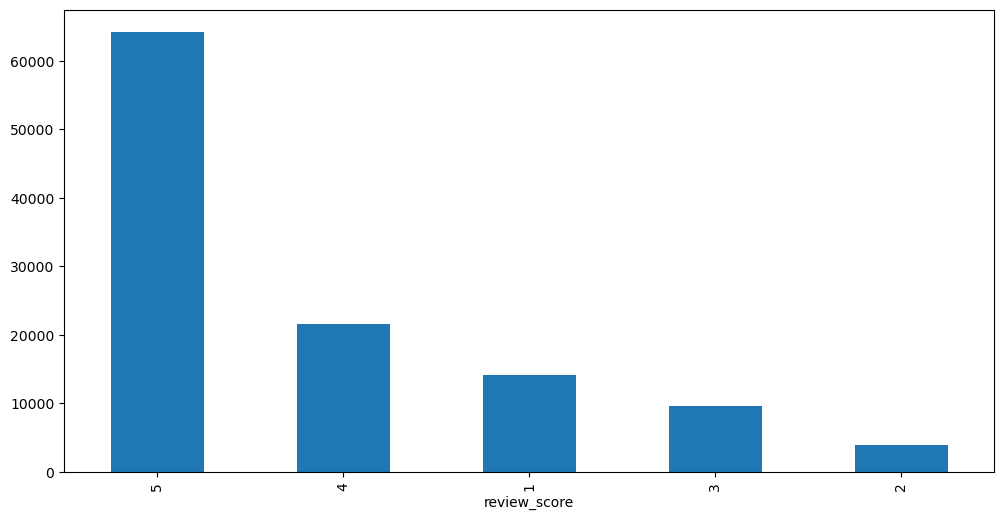

In [230]:
plt.figure(figsize=(12, 6))
df['review_score'].value_counts().plot(kind='bar')
plt.show()

The distribution is skewed
to
the
right.Over
50 % of
the
ratings
are
5, followed
by
a
little
below
20 %
with 4 star ratings.And the percentages of ratings keep going down until below 10 %of the ratings are 2 stars.


In [234]:
df_subset.shape

(103730, 25)

In [235]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_subset['customer_unique_id'].nunique())
print('Number of unique Orders in Raw data = ', df_subset['customer_id'].nunique())
print('Number of unique Products in Raw data = ', df_subset['product_id'].nunique())
print('Number of valid reviews: ', df_subset[df_subset['review_score'] != 0].shape[0])

Number of unique USERS in Raw data =  82523
Number of unique Orders in Raw data =  85550
Number of unique Products in Raw data =  30410
Number of valid reviews:  103730


In [238]:
df_subset[df_subset.duplicated()].shape

(35, 25)

Drop duplicated rows

In [241]:
df_subset.drop_duplicates(inplace=True)

In [243]:
df_subset.shape

(103695, 25)

In [245]:

review_prod = df_subset.groupby(['customer_unique_id', 'product_id']).agg(mean_rating=('review_score', 'mean')).reset_index()
print('Total number of unique product orders: ', review_prod.shape[0])
print('Number of reviews:', review_prod[review_prod['mean_rating'] > 0].shape[0])


Total number of unique product orders:  88736
Number of reviews: 88736


In [247]:

counts = df_subset['customer_unique_id'].value_counts()
counts

customer_unique_id
f9ae226291893fda10af7965268fb7f6    35
6fbc7cdadbb522125f4b27ae9dee4060    34
9a736b248f67d166d2fbb006bcb877c3    30
8af7ac63b2efbcbd88e5b11505e8098a    25
d97b3cfb22b0d6b25ac9ed4e9c2d481b    24
                                    ..
80306ad48106ea04b344807c50fec01d     1
ea7ef5bb16a8ba2a4756e74032b737b7     1
65228ee90c5cd97c7ac393bc7cdabb3d     1
eb70e70ab5935a82bf4512d0a08596c5     1
a74743ec8de47aebda376d7e00a69739     1
Name: count, Length: 82523, dtype: int64

In [249]:
from sklearn.preprocessing import LabelEncoder
u_transf = LabelEncoder()
item_transf = LabelEncoder()
# encoding
df_subset['customer_unique_id'] = u_transf.fit_transform(df_subset['customer_unique_id'])
df_subset['product_id'] = item_transf.fit_transform(df_subset['product_id'])
# decoding
#df_subset['product_id']= item_transf.inverse_transform(df_subset['product_id'])
#df_subset['customer_unique_id'] = u_transf.inverse_transform(df_subset['customer_unique_id'])

In [251]:
df_subset.head()

,total_value,price,review_score,order_item_quantity,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,customer_state,review_id,product_id,seller_id,product_category,seller_city,seller_state,order_purchased_at,order_approved_at,order_estimated_delivery_date
0,2.950735,29.99,4,0.693147,8.72,4.0,500.0,19.0,8.0,13.0,...,SP,a54f0611adc9ed256b57ede6b6eb5114,16086,3504c0cb71d7fa48d967e0e4c94d59d9,household_utilities,maua,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18
1,2.975019,29.99,4,0.693147,8.72,4.0,500.0,19.0,8.0,13.0,...,SP,a54f0611adc9ed256b57ede6b6eb5114,16086,3504c0cb71d7fa48d967e0e4c94d59d9,household_utilities,maua,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18
2,4.959061,118.70,4,0.693147,22.76,1.0,400.0,19.0,13.0,19.0,...,SP,a54f0611adc9ed256b57ede6b6eb5114,16086,3504c0cb71d7fa48d967e0e4c94d59d9,household_utilities,maua,SP,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-18
3,5.193623,159.90,5,0.693147,19.22,1.0,420.0,24.0,19.0,21.0,...,BA,8d5266042046a06655c8db133d120ba5,10723,289cdb325fb7e7f891c38608bf9e0962,perfumery,belo horizonte,SP,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-13
4,4.293195,45.00,5,0.693147,27.20,3.0,450.0,30.0,10.0,20.0,...,GO,e73b67b67587f7644d5bd1a52deb1b01,20127,4869f7a5dfa277a7dca6462dcf3b52b2,automobile,guariba,SP,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-09-04


In [253]:
def reduce_sparsity(df, min_items_per_user, min_user_per_item, user_col='customer_unique_id', item_col='product_id'):
    good_users = df[user_col].value_counts()[df[user_col].value_counts() > min_items_per_user].index
    df = df[df[user_col].isin(good_users)]

    good_items = df[item_col].value_counts()[df[item_col].value_counts() > min_user_per_item].index
    df = df[df[item_col].isin(good_items)].reset_index(drop=1)

    return df

In [255]:
df_final_1=reduce_sparsity(df_subset, 1, 6)
df_final_1

,total_value,price,review_score,order_item_quantity,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,customer_state,review_id,product_id,seller_id,product_category,seller_city,seller_state,order_purchased_at,order_approved_at,order_estimated_delivery_date
0,4.746062,98.00,4,0.693147,16.13,1.0,325.0,21.0,21.0,21.0,...,RJ,15898b543726a832d4137fbef5d1d00e,987,001cca7ae9ae17fb1caed9dfb1094831,garden_tools,cariacica,ES,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-06-07
1,3.934371,31.90,5,0.693147,18.23,1.0,450.0,16.0,17.0,16.0,...,RJ,15898b543726a832d4137fbef5d1d00e,987,001cca7ae9ae17fb1caed9dfb1094831,garden_tools,cariacica,ES,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-06-07
2,4.422809,69.90,5,0.693147,12.43,6.0,2600.0,50.0,10.0,30.0,...,SP,5853e27c64b89e222c5e4edf78bec3d4,23432,e9779976487b77c6d4ac45f75ec7afe9,health_beauty,praia grande,SP,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-28
3,6.716304,329.90,3,1.098612,82.48,1.0,10000.0,30.0,20.0,30.0,...,MG,c7862c2b2f4259f9b1173a9c14e737e5,24989,a1043bafd471dff536d0c462352beb48,computers_accessories,ilicinea,MG,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-05-15
4,5.975335,84.90,5,1.609438,13.25,1.0,150.0,16.0,6.0,11.0,...,SP,0047ca502c37fbba9b3a31eeae3fe0c2,19690,817245bcc3badd82bbd222e0366951a6,automobile,bauru,SP,2018-06-18 16:02:23,2018-06-18 17:00:57,2018-07-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12663,4.359653,59.90,5,0.693147,17.33,3.0,2050.0,50.0,10.0,40.0,...,RJ,caaac848110409f69b7b90c5a4cc4c94,26482,262237171f48e85819065498cac80d7b,sport_leisure,brusque,SC,2017-08-02 08:58:27,2017-08-04 11:33:49,2017-08-28
12664,3.658936,24.98,4,0.693147,12.84,1.0,350.0,16.0,16.0,17.0,...,RJ,caaac848110409f69b7b90c5a4cc4c94,26482,262237171f48e85819065498cac80d7b,sport_leisure,brusque,SC,2017-08-02 08:58:27,2017-08-04 11:33:49,2017-08-28
12665,4.703204,98.00,5,0.693147,11.30,3.0,275.0,16.0,11.0,11.0,...,SE,6116d3fa41da9c40104c4c1f52d32358,6432,897060da8b9a21f655304d50fd935913,computers_accessories,ribeirao preto,SP,2017-09-19 09:28:22,2017-09-20 02:36:27,2017-10-16
12666,4.457250,57.99,5,0.693147,27.26,1.0,350.0,19.0,12.0,13.0,...,PB,722a233d01008eef753e06fb5256a248,25446,25c5c91f63607446a97b143d2d535d31,computers_accessories,itauna,MG,2017-06-05 08:57:55,2017-06-06 13:23:15,2017-07-06


In [257]:
df_final_1.shape

(12668, 25)

In [259]:
df_final = df_final_1

In [261]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['customer_unique_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['product_id'].nunique())

The number of observations in the final data = 12668
Number of unique USERS in the final data =  5365
Number of unique PRODUCTS in the final data =  828


In [263]:
df_final.head()

,total_value,price,review_score,order_item_quantity,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,customer_state,review_id,product_id,seller_id,product_category,seller_city,seller_state,order_purchased_at,order_approved_at,order_estimated_delivery_date
0,4.746062,98.0,4,0.693147,16.13,1.0,325.0,21.0,21.0,21.0,...,RJ,15898b543726a832d4137fbef5d1d00e,987,001cca7ae9ae17fb1caed9dfb1094831,garden_tools,cariacica,ES,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-06-07
1,3.934371,31.9,5,0.693147,18.23,1.0,450.0,16.0,17.0,16.0,...,RJ,15898b543726a832d4137fbef5d1d00e,987,001cca7ae9ae17fb1caed9dfb1094831,garden_tools,cariacica,ES,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-06-07
2,4.422809,69.9,5,0.693147,12.43,6.0,2600.0,50.0,10.0,30.0,...,SP,5853e27c64b89e222c5e4edf78bec3d4,23432,e9779976487b77c6d4ac45f75ec7afe9,health_beauty,praia grande,SP,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-28
3,6.716304,329.9,3,1.098612,82.48,1.0,10000.0,30.0,20.0,30.0,...,MG,c7862c2b2f4259f9b1173a9c14e737e5,24989,a1043bafd471dff536d0c462352beb48,computers_accessories,ilicinea,MG,2018-04-22 08:48:13,2018-04-24 18:25:22,2018-05-15
4,5.975335,84.9,5,1.609438,13.25,1.0,150.0,16.0,6.0,11.0,...,SP,0047ca502c37fbba9b3a31eeae3fe0c2,19690,817245bcc3badd82bbd222e0366951a6,automobile,bauru,SP,2018-06-18 16:02:23,2018-06-18 17:00:57,2018-07-13


In [128]:
# prompt: subset the dataset with only customer_unique_id, product_id, ratings

df_1 = df_final[['customer_unique_id', 'product_id', 'review_score']]
df_1

,customer_unique_id,product_id,review_score
0,78278,987,4
1,78278,987,5
2,2933,23432,5
3,4643,24989,3
4,53049,19690,5
...,...,...,...
12663,72329,26482,5
12664,72329,26482,4
12665,79322,6432,5
12666,59449,25446,5


In [130]:
# prompt: Check duplicates in df_1

# Check for duplicates in df_1
duplicates = df_1[df_1.duplicated()]
print("Duplicate Rows:")
print(duplicates)

# Number of duplicate rows
num_duplicates = len(duplicates)
print(f"\nNumber of duplicate rows: {num_duplicates}")

Duplicate Rows:
       customer_unique_id  product_id  review_score
5                   53049       19690             5
7                   53049       19690             5
9                   80629       19609             1
11                  80629       19609             5
12                  80629       19609             5
...                   ...         ...           ...
12657               49101       10894             5
12659               36249        6521             5
12662               72329       26482             5
12663               72329       26482             5
12667               59449       25446             5

[3676 rows x 3 columns]

Number of duplicate rows: 3676


In [336]:
import pandas as pd
from surprise import Dataset, Reader, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy

In [134]:
# Drop duplicates
df_1 = df_1.drop_duplicates()

In [135]:
#reset index for df_1

df_1 = df_1.reset_index(drop=True)

In [136]:
# Create a Surprise Reader object, specifying the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataframe into a Surprise Dataset
data = Dataset.load_from_df(df_1, reader)


# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)

# Initialize the SVD algorithm (you can adjust parameters as needed)
algo = SVDpp()

# Train the algorithm on the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

In [137]:
# Evaluate the testset (example: RMSE)
RMSE_test = accuracy.rmse(predictions)
RMSE_test

RMSE: 1.5421


1.5421400509060157

In [138]:
predictions_train = algo.test(trainset.build_testset())  # Use build_testset()

# Evaluate the trainset (example: RMSE)
RMSE_train = accuracy.rmse(predictions_train)
RMSE_train

RMSE: 1.1787


1.1787380580211506

## Cross Validation

In [139]:
from surprise.model_selection import cross_validate
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5247  1.5619  1.5538  1.5501  1.5572  1.5496  0.0130  
MAE (testset)     1.2498  1.3023  1.2707  1.2730  1.2678  1.2727  0.0169  
Fit time          0.03    0.03    0.03    0.03    0.03    0.03    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.52474877, 1.56193112, 1.553828  , 1.55014021, 1.55720371]),
 'test_mae': array([1.24980835, 1.30227028, 1.27066986, 1.27304116, 1.26783669]),
 'fit_time': (0.03138613700866699,
  0.030209064483642578,
  0.030514955520629883,
  0.030657052993774414,
  0.030790090560913086),
 'test_time': (0.006216764450073242,
  0.006047964096069336,
  0.005866050720214844,
  0.006413936614990234,
  0.006184101104736328)}

## Generate Recommendations

In [140]:
# prompt: How to use the above svdpp model to get product recommendations for a particular user?

def get_product_recommendations(user_id, num_recommendations=10):
    """
    Recommends products for a given user using the trained SVDpp model.

    Args:
        user_id: The ID of the user for whom to generate recommendations.
        num_recommendations: The number of product recommendations to return.

    Returns:
        A list of product IDs representing the recommended products.
    """

    # Get the inner user ID from the Surprise dataset
    try:
        inner_user_id = algo.trainset.to_inner_uid(user_id)
    except ValueError:  # Handle cases where user_id is not in the training set
        print(f"User ID {user_id} not found in the training data. Cannot provide recommendations.")
        return []

    # Predict ratings for all products for this user
    predictions = []
    for product_id in df_1['product_id'].unique():
        predictions.append(algo.predict(user_id, product_id))

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get the top N recommendations
    recommended_product_ids = [prediction.iid for prediction in predictions[:num_recommendations]]

    return recommended_product_ids


In [ ]:
#get list of user_id in predictions (Test set) to check recommendations

# Assuming 'predictions' is the list of predictions from the SVDpp model
user_ids = [pred.uid for pred in predictions]
#user_ids

In [164]:
# Example usage:
user_id_to_recommend = 3333  # Replace with the actual user ID
recommendations = get_product_recommendations(user_id_to_recommend)

if recommendations:
    print(f"Top {len(recommendations)} product recommendations for user {user_id_to_recommend}:")
recommendations

Top 10 product recommendations for user 3333:


[29547, 15647, 10545, 12917, 21925, 10019, 13783, 28729, 20967, 27230]

## Evaluation

In [371]:
from collections import defaultdict

In [379]:

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print('Precision at 5: ', sum(prec for prec in precisions.values()) / len(precisions))
print('Recall at 5: ', sum(rec for rec in recalls.values()) / len(recalls))

Precision at 5:  0.2942314160780357
Recall at 5:  0.3007063572149344
